# NanoPyx "Codeless" Jupyter Notebook

### This notebook allows you to assess quality control metrics of microscopy images such as an Error Map (NanoJ-SQUIRREL), FRC (Fourier Ring Correlation) and Decorrelation analysis.
  
### To use this notebook you don't need to interact with any code, just run cells in order and a graphical user interface will pop-up showcasing the parameters for each step
  
**SRRF**: Culley S, Tosheva KL, Matos Pereira P, Henriques R. SRRF: Universal live-cell super-resolution microscopy. Int J Biochem Cell Biol. 2018 Aug;101:74-79. doi: 10.1016/j.biocel.2018.05.014. Epub 2018 May 28. PMID: 29852248; PMCID: PMC6025290.

**Error Map**: Culley, S., Albrecht, D., Jacobs, C. et al. Quantitative mapping and minimization of super-resolution optical imaging artifacts. Nat Methods 15, 263–266 (2018). https://doi.org/10.1038/nmeth.4605
  
**FRC**: Nieuwenhuizen RP, Lidke KA, Bates M, Puig DL, Grünwald D, Stallinga S, Rieger B. Measuring image resolution in optical nanoscopy. Nat Methods. 2013 Jun;10(6):557-62. doi: 10.1038/nmeth.2448. Epub 2013 Apr 28. PMID: 23624665; PMCID: PMC4149789.  
  
**DecorrAnalysis**: Descloux A, Grußmayer KS, Radenovic A. Parameter-free image resolution estimation based on decorrelation analysis. Nat Methods. 2019 Sep;16(9):918-924. doi: 10.1038/s41592-019-0515-7. Epub 2019 Aug 26. PMID: 31451766.  

## Notebook setup cell
Run the following cell to install nanopyx

In [ ]:
!pip install git+https://github.com/HenriquesLab/NanoPyx.git

Now, import all necessary python libraries

In [1]:
import io
import os
import skimage
import numpy as np
import tifffile as tiff
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

from nanopyx.core.utils.easy_gui import EasyGui
from nanopyx.core.utils.find_files import find_files
from nanopyx.data.download import ExampleDataManager
from nanopyx.core.utils.easy_gui import view_image_stack, view_curtain_stack, view_image

## Load difraction limited image (only needed if you want to use the FRC and Decorrelation analysis on this image or if you want to perform the Error Map analysis)

Label(value='Select data to use:', layout=Layout(width='50%'), style=LabelStyle(description_width='initial'))

FileChooser(path='/Users/bsaraiva/Code/NanoPyx/notebooks', filename='', title='', show_hidden=False, select_de…

Button(description='Load data', layout=Layout(width='50%'), style=ButtonStyle())

interactive(children=(IntSlider(value=0, description='dim0', max=499), Output()), _dom_classes=('widget-intera…

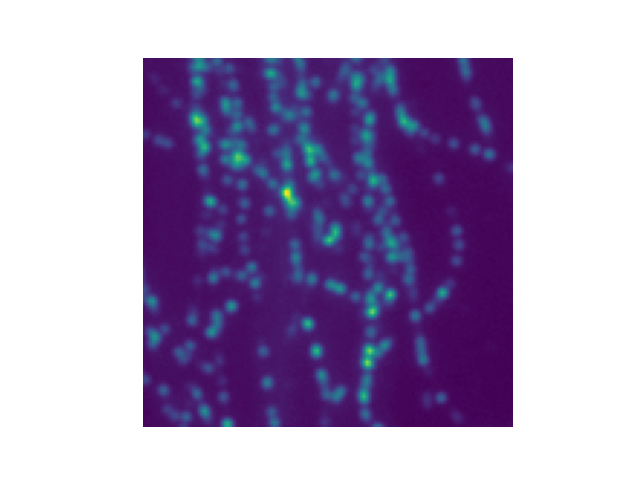

In [5]:
%matplotlib widget
# Create a GUI
gui_data = EasyGui("Data Loader")

def on_button_load_data_clicked(b):
    clear_output()
    gui_data.show()
    global dataset_df
    # disable button
    gui_data["load_data"].disabled = True
    gui_data["load_data"].description = "Loading..."
    dataset_df = tiff.imread(gui_data["upload"].selected)
    gui_data["load_data"].disabled = False
    gui_data["load_data"].description = "Load data"
    view_image_stack(dataset_df)

gui_data.add_label("Select data to use:")
gui_data.add_file_upload("upload")
gui_data.add_button("load_data", description="Load data")
gui_data["load_data"].on_click(on_button_load_data_clicked)
gui_data.show()

## Load super-resolved image

Label(value='Select data to use:', layout=Layout(width='50%'), style=LabelStyle(description_width='initial'))

FileChooser(path='/Users/bsaraiva/Code/NanoPyx/notebooks', filename='', title='', show_hidden=False, select_de…

Button(description='Load data', layout=Layout(width='50%'), style=ButtonStyle())

interactive(children=(IntSlider(value=0, description='dim0', max=1), Output()), _dom_classes=('widget-interact…

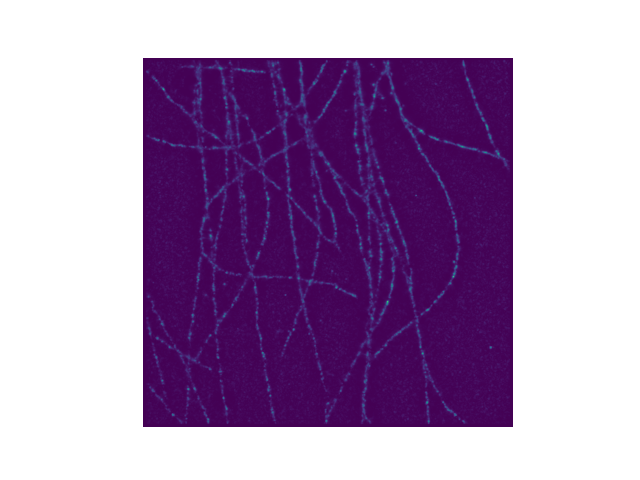

In [ ]:
%matplotlib widget
# Create a GUI
gui_data_sr = EasyGui("Data Loader")

def on_button_load_data_clicked(b):
    clear_output()
    gui_data_sr.show()
    global dataset_sr
    # disable button
    gui_data_sr["load_data"].disabled = True
    gui_data_sr["load_data"].description = "Loading..."
    dataset_sr = tiff.imread(gui_data_sr["upload"].selected)
    gui_data_sr["load_data"].disabled = False
    gui_data_sr["load_data"].description = "Load data"
    view_image_stack(dataset_sr)

gui_data_sr.add_label("Select data to use:")
gui_data_sr.add_file_upload("upload")
gui_data_sr.add_button("load_data", description="Load data")
gui_data_sr["load_data"].on_click(on_button_load_data_clicked)
gui_data_sr.show()

## Calculate Error Map

Checkbox(value=True, description='Save output', layout=Layout(width='50%'), style=CheckboxStyle(description_wi…

Button(description='Calculate', layout=Layout(width='50%'), style=ButtonStyle())

RSE:  61.11342239379883
RSP:  0.88729327917099


interactive(children=(Output(),), _dom_classes=('widget-interact',))

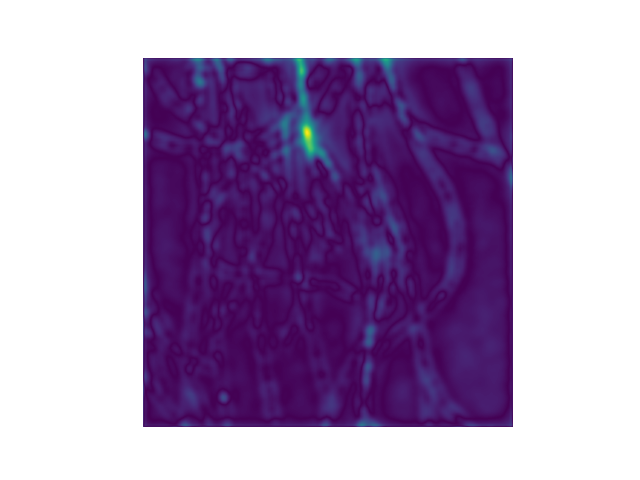

In [8]:
gui_error = EasyGui("Error")

import numpy as np
from matplotlib import pyplot as plt
from nanopyx.core.transform.new_error_map import ErrorMap

def run_error(b):
    clear_output()
    gui_error.show()
    gui_error.save_settings()
    gui_error["run"].disabled = True
    gui_error["run"].description = "Calculating..."
    global error_map
    error_map = ErrorMap()
    if len(dataset_df.shape) > 2:
        df = np.mean(dataset_df, axis=0)
    else:
        df = dataset_df
    if len(dataset_sr.shape) > 2:
        sr = np.mean(dataset_sr, axis=0)
    else:
        sr = dataset_sr
    error_map.optimise(df, sr)
    gui_error["run"].disabled = False
    gui_error["run"].description = "Calculate"
    print("RSE: ", error_map.getRSE())
    print("RSP: ", error_map.getRSP())
    error_map = np.array(error_map.imRSE)
    if gui_error["save"].value:
        path = gui_data_sr["upload"].selected_path
        name = gui_data_sr["upload"].selected_filename.split(".")[0]
        tiff.imwrite(path + os.sep + name + "_error_map.tif", error_map)
    view_image_stack(error_map)
    
gui_error.add_checkbox("save", description="Save output", value=True)
gui_error.add_button("run", description="Calculate")
gui_error["run"].on_click(run_error)
gui_error.show()

## Run this cell to perform FRC analysis on the difraction limited image

IntSlider(value=100, description='Pixel Size:', layout=Layout(width='50%'), max=1000, style=SliderStyle(descri…

Dropdown(description='Units: ', layout=Layout(width='50%'), options=('nm', 'um', 'mm'), style=DescriptionStyle…

IntSlider(value=0, description='First Frame:', layout=Layout(width='50%'), max=127, style=SliderStyle(descript…

IntSlider(value=1, description='Second Frame:', layout=Layout(width='50%'), max=127, style=SliderStyle(descrip…

Checkbox(value=True, description='Save Output', layout=Layout(width='50%'), style=CheckboxStyle(description_wi…

Button(description='Calculate', layout=Layout(width='50%'), style=ButtonStyle())

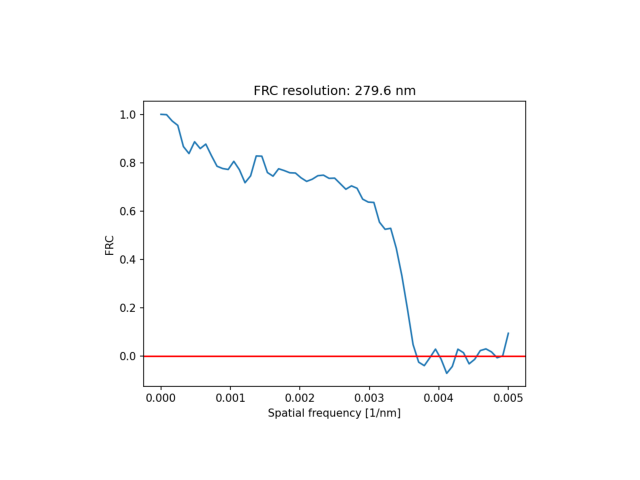

No such comm: 5f6608fc9a2243c39c425594cdfa376c
No such comm: 5f6608fc9a2243c39c425594cdfa376c
No such comm: 5f6608fc9a2243c39c425594cdfa376c
No such comm: 5f6608fc9a2243c39c425594cdfa376c


In [ ]:
gui_frc_1 = EasyGui("FRC")

import numpy as np
from nanopyx.core.analysis.frc import FIRECalculator

def run_frc(b):
    clear_output()
    gui_frc_1.show()
    gui_frc_1.save_settings()
    pixel_size = gui_frc_1["pixel_size"].value
    units = gui_frc_1["units"].value
    first_frame = gui_frc_1["first_frame"].value
    second_frame = gui_frc_1["second_frame"].value
    gui_frc_1["run"].disabled = True
    gui_frc_1["run"].description = "Calculating..."
    global frc_calculator_raw
    frc_calculator_raw = FIRECalculator(pixel_size=pixel_size, units=units)
    frc_calculator_raw.calculate_fire_number(dataset_df[first_frame], dataset_df[second_frame])
    gui_frc_1["run"].disabled = False
    gui_frc_1["run"].description = "Calculate"
    plot = frc_calculator_raw.plot_frc_curve()
    if gui_frc_1["save"].value:
        path = gui_data["upload"].selected_path
        name = gui_data["upload"].selected_filename.split(".")[0]
        tiff.imwrite(path + os.sep + name + "_original_FRC.tif", plot)
    view_image(plot)
    
gui_frc_1.add_int_slider("pixel_size", description="Pixel Size:", min=0.01, max=1000, value=100, remember_value=True)
gui_frc_1.add_dropdown("units", description="Units: ", options=["nm", "um", "mm"], value="nm")
gui_frc_1.add_int_slider("first_frame", description="First Frame:", min=0, max=dataset_df[0].shape[0]-1, value=0)
gui_frc_1.add_int_slider ("second_frame", description="Second Frame:", min=0, max=dataset_df[0].shape[0]-1, value=1)
gui_frc_1.add_checkbox("save", description="Save Output", value=True)
gui_frc_1.add_button("run", description="Calculate")
gui_frc_1["run"].on_click(run_frc)
gui_frc_1.show()

## Run this cell to perform FRC on the super-resolved image

IntSlider(value=20, description='Pixel Size:', layout=Layout(width='50%'), max=1000, style=SliderStyle(descrip…

Dropdown(description='Units: ', layout=Layout(width='50%'), options=('nm', 'um', 'mm'), style=DescriptionStyle…

IntSlider(value=0, description='First Frame:', layout=Layout(width='50%'), max=639, style=SliderStyle(descript…

IntSlider(value=1, description='Second Frame:', layout=Layout(width='50%'), max=639, style=SliderStyle(descrip…

Checkbox(value=True, description='Save Ouput', layout=Layout(width='50%'), style=CheckboxStyle(description_wid…

Button(description='Calculate', layout=Layout(width='50%'), style=ButtonStyle())

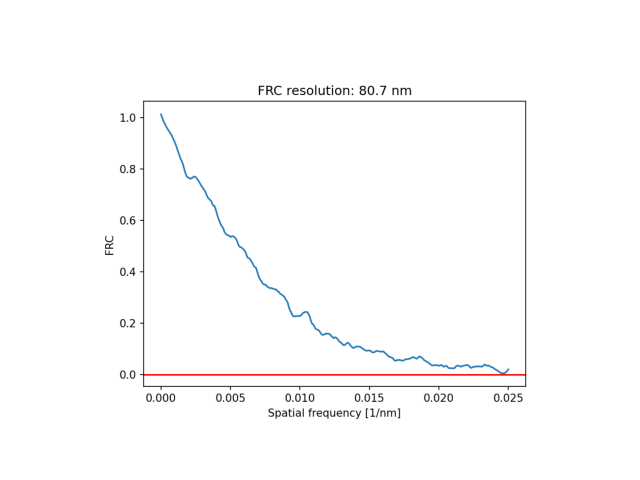

No such comm: 966635effff3453a9c43d31f42cbef05
No such comm: 966635effff3453a9c43d31f42cbef05
No such comm: 966635effff3453a9c43d31f42cbef05
No such comm: 966635effff3453a9c43d31f42cbef05


In [ ]:
gui_frc = EasyGui("FRC")

from nanopyx.core.analysis.frc import FIRECalculator

def run_frc(b):
    clear_output()
    gui_frc.show()
    gui_frc.save_settings()
    pixel_size = gui_frc["pixel_size"].value
    units = gui_frc["units"].value
    first_frame = gui_frc["first_frame"].value
    second_frame = gui_frc["second_frame"].value
    gui_frc["run"].disabled = True
    gui_frc["run"].description = "Calculating..."
    global frc_calculator
    frc_calculator = FIRECalculator(pixel_size=pixel_size, units=units)
    frc_calculator.calculate_fire_number(dataset_sr[first_frame], dataset_sr[second_frame])
    gui_frc["run"].disabled = False
    gui_frc["run"].description = "Calculate"
    plot = frc_calculator.plot_frc_curve()
    if gui_frc["save"].value:
        path = gui_data["upload"].selected_path
        name = gui_data["upload"].selected_filename.split(".")[0]
        tiff.imwrite(path + os.sep + name + "_SRRF_FRC.tif", plot)
    view_image(plot)
    
gui_frc.add_int_slider("pixel_size", description="Pixel Size:", min=0.01, max=1000, value=20, remember_value=True)
gui_frc.add_dropdown("units", description="Units: ", options=["nm", "um", "mm"], value="nm")
gui_frc.add_int_slider("first_frame", description="First Frame:", min=0, max=dataset_sr[0].shape[0]-1, value=0)
gui_frc.add_int_slider ("second_frame", description="Second Frame:", min=0, max=dataset_sr[0].shape[0]-1, value=1)
gui_frc.add_checkbox("save", description="Save Ouput", value=True)
gui_frc.add_button("run", description="Calculate")
gui_frc["run"].on_click(run_frc)
gui_frc.show()

## Run this cell to perform decorrelation analysis on the difraction limited image

IntSlider(value=100, description='Pixel Size:', layout=Layout(width='50%'), max=1000, style=SliderStyle(descri…

Dropdown(description='Units: ', layout=Layout(width='50%'), options=('nm', 'um', 'mm'), style=DescriptionStyle…

FloatSlider(value=0.0, description='Radius Min:', layout=Layout(width='50%'), max=0.5, style=SliderStyle(descr…

FloatSlider(value=1.0, description='Radius Max:', layout=Layout(width='50%'), max=1.0, min=0.5, style=SliderSt…

Checkbox(value=True, description='Save Output', layout=Layout(width='50%'), style=CheckboxStyle(description_wi…

Button(description='Calculate', layout=Layout(width='50%'), style=ButtonStyle())

run_analysis took 18.885851 mseconds


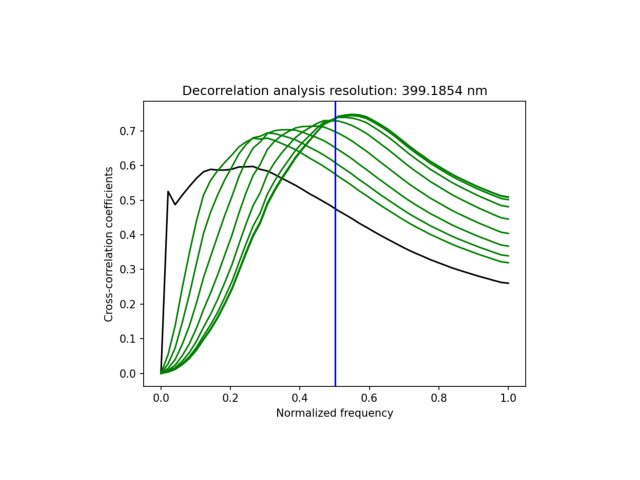

No such comm: 1c577a1e09fb47d5a18f34cbb9eb73ea
No such comm: 1c577a1e09fb47d5a18f34cbb9eb73ea
No such comm: 1c577a1e09fb47d5a18f34cbb9eb73ea
No such comm: 1c577a1e09fb47d5a18f34cbb9eb73ea


In [12]:
gui_decorr_1 = EasyGui("DecorrAnalysis")

from nanopyx.core.analysis.decorr import DecorrAnalysis

def run_decorr(b):
    clear_output()
    gui_decorr_1.show()
    gui_decorr_1.save_settings()
    pixel_size = gui_decorr_1["pixel_size"].value
    units = gui_decorr_1["units"].value
    rmin = gui_decorr_1["rmin"].value
    rmax = gui_decorr_1["rmax"].value
    gui_decorr_1["run"].disabled = True
    gui_decorr_1["run"].description = "Calculating..."
    global decorr_calculator_raw
    decorr_calculator_raw = DecorrAnalysis(pixel_size=pixel_size, units=units, rmin=rmin, rmax=rmax)
    if len(dataset_df.shape) > 2:
        df = np.mean(dataset_df, axis=0)
    else:
        df = dataset_df
    decorr_calculator_raw.run_analysis(df)
    gui_decorr_1["run"].disabled = False
    gui_decorr_1["run"].description = "Calculate"
    plot = decorr_calculator_raw.plot_results()
    if gui_decorr_1["save"].value:
        path = gui_data["upload"].selected_path
        name = gui_data["upload"].selected_filename.split(".")[0]
        tiff.imwrite(path + os.sep + name + "_original_decorr_analysis.tif", plot)
    view_image(plot)
    
gui_decorr_1.add_int_slider("pixel_size", description="Pixel Size:", min=0.01, max=1000, value=100, remember_value=True)
gui_decorr_1.add_dropdown("units", description="Units: ", options=["nm", "um", "mm"], value="nm")
gui_decorr_1.add_float_slider("rmin", description="Radius Min:", min=0.0, max=0.5, value=0.0)
gui_decorr_1.add_float_slider("rmax", description="Radius Max:", min=0.5, max=1.0, value=1.0)
gui_decorr_1.add_checkbox("save", description="Save Output", value=True)
gui_decorr_1.add_button("run", description="Calculate")
gui_decorr_1["run"].on_click(run_decorr)
gui_decorr_1.show()

## Run this cell to perform decorrelation analysis on the super-resolved image

IntSlider(value=20, description='Pixel Size:', layout=Layout(width='50%'), max=1000, style=SliderStyle(descrip…

Dropdown(description='Units: ', layout=Layout(width='50%'), options=('nm', 'um', 'mm'), style=DescriptionStyle…

FloatSlider(value=0.0, description='Radius Min:', layout=Layout(width='50%'), max=0.5, style=SliderStyle(descr…

FloatSlider(value=1.0, layout=Layout(width='50%'), max=1.0, min=0.5, style=SliderStyle(description_width='init…

Checkbox(value=True, description='Save Output', layout=Layout(width='50%'), style=CheckboxStyle(description_wi…

Button(description='Calculate', layout=Layout(width='50%'), style=ButtonStyle())

run_analysis took 1.510655 seconds


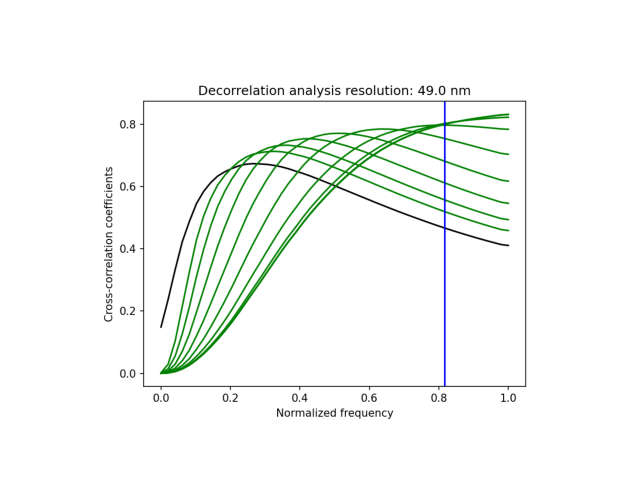

No such comm: a72dc1a0f778456186c8b0eb20f5f012
No such comm: a72dc1a0f778456186c8b0eb20f5f012
No such comm: a72dc1a0f778456186c8b0eb20f5f012
No such comm: a72dc1a0f778456186c8b0eb20f5f012


In [ ]:
gui_decorr = EasyGui("DecorrAnalysis")

from nanopyx.core.analysis.decorr import DecorrAnalysis

def run_decorr(b):
    clear_output()
    gui_decorr.show()
    gui_decorr.save_settings()
    pixel_size = gui_decorr["pixel_size"].value
    units = gui_decorr["units"].value
    rmin = gui_decorr["rmin"].value
    rmax = gui_decorr["rmax"].value
    gui_decorr["run"].disabled = True
    gui_decorr["run"].description = "Calculating..."
    global decorr_calculator
    decorr_calculator = DecorrAnalysis(pixel_size=pixel_size, units=units, rmin=rmin, rmax=rmax)
    if len(dataset_sr.shape) > 2:
        sr = np.mean(dataset_sr, axis=0)
    else:
        sr = dataset_sr
    decorr_calculator.run_analysis(sr)
    gui_decorr["run"].disabled = False
    gui_decorr["run"].description = "Calculate"
    plot = decorr_calculator.plot_results()
    if gui_decorr["save"].value:
        path = gui_data["upload"].selected_path
        name = gui_data["upload"].selected_filename.split(".")[0]
        tiff.imwrite(path + os.sep + name + "_SRRF_decorr_analysis.tif", plot)
    view_image(plot)
    
gui_decorr.add_int_slider("pixel_size", description="Pixel Size:", min=0.01, max=1000, value=100, remember_value=True)
gui_decorr.add_dropdown("units", description="Units: ", options=["nm", "um", "mm"], value="nm")
gui_decorr.add_float_slider("rmin", description="Radius Min:", min=0.0, max=0.5, value=0.0)
gui_decorr.add_float_slider("rmax", desctiption="Radius Max:", min=0.5, max=1.0, value=1.0)
gui_decorr.add_checkbox("save", description="Save Output", value=True)
gui_decorr.add_button("run", description="Calculate")
gui_decorr["run"].on_click(run_decorr)
gui_decorr.show()